In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# %matplotlib inline
%matplotlib qt
# sns.set_context('paper', font_scale=1.5)

import os, glob
from pathlib import Path
from scipy import stats, interpolate, signal
from scipy.signal import welch, butter, filtfilt
from nolds import sampen
from scipy.ndimage import gaussian_filter1d

from HelperFcns import *

%load_ext autoreload
%autoreload 2

In [2]:
plt.close('all')

In [3]:
#load poses
path = '/Users/luca/Box/CISPD_Videos_proc/Metadata/'
#load data
df = pd.read_csv(os.path.join(path, 'PosesPat.csv'))
df.index = df['FrameID']
df.head()

,SubjID,Task,cycle,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,...,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c,PersonID,FrameID,NPerson
FrameID,,,,,,,,,,,,,,,,,,,,,
0,1005,FtnL,1,665.729,792.330,0.766920,868.719,836.455,0.802609,786.395,...,0.659051,944.507,532.372,0.632399,944.507,544.356,0.623629,1,0,3
1,1005,FtnL,1,665.653,795.175,0.750911,865.876,836.453,0.808026,789.355,...,0.647635,943.553,532.087,0.596038,942.785,544.374,0.615199,1,1,3
2,1005,FtnL,1,665.679,795.244,0.742167,865.785,836.502,0.809571,792.186,...,0.616394,843.683,413.160,0.822903,861.124,434.393,0.663917,1,2,3
3,1005,FtnL,1,665.627,792.313,0.760414,862.942,836.496,0.815405,792.326,...,0.804164,842.660,412.750,0.849422,858.018,431.180,0.762118,1,3,3
4,1005,FtnL,1,665.620,795.171,0.755462,862.911,836.500,0.817131,795.149,...,0.656123,843.071,412.394,0.805221,860.170,431.824,0.758662,1,4,3


In [4]:
#load scores
# scores = pd.read_csv('/Users/luca/Box/CISPD_Videos_proc/Metadata/Table4.csv')
tasks = ['RamL', 'RamR']
scores = pd.read_csv(path+'/Table4.csv')
scores = scores.loc[(scores['SubjID'].isin(df.SubjID.unique())) & (scores.TaskAbb.isin(tasks))]
scores = scores[['SubjID','Visit','TaskAbb','Tremor - Left', 'Tremor - Right', 
                 'Bradykinesia - Right', 'Bradykinesia - Left','Dyskinesia - Left','Dyskinesia - Right']]
scores.rename(columns={'Tremor - Right':'Tremor - R', 'Tremor - Left':'Tremor - L',
                      'Bradykinesia - Right': 'Bradykinesia - R',
                      'Bradykinesia - Left': 'Bradykinesia - L',
                      'Dyskinesia - Left': 'Dyskinesia - L',
                      'Dyskinesia - Right': 'Dyskinesia - R'}, inplace=True)
scores.query('Visit != "1 Month"', inplace=True)
scores['Visit']=scores.Visit.apply(lambda x: x.split()[-1])
for i,j in enumerate(scores.Visit.unique()):
    print(i,j)
    scores.loc[scores.Visit==j, 'Visit'] = i+1
scores = scores.query('Visit ==1 | Visit ==2 | Visit==3')
scores.head(2)

0 0
1 30
2 60
3 90
4 120
5 150


,SubjID,Visit,TaskAbb,Tremor - L,Tremor - R,Bradykinesia - R,Bradykinesia - L,Dyskinesia - L,Dyskinesia - R
216,1005,1,RamL,1.0,0.0,NaN,3.0,0.0,0.0
217,1005,1,RamR,0.0,0.0,1.0,NaN,0.0,0.0


In [5]:
#distribution of symptoms
plt.close('all')
for task in tasks:
    plt.figure()
    scores.query('TaskAbb==@task').iloc[:,3:].plot(kind='hist', subplots=True)
    plt.suptitle(task)

## Compute features for both sides

In [263]:
df.columns

Index(['SubjID', 'Task', 'cycle', 'elbR_x', 'elbR_y', 'elbR_c', 'wriR_x',
       'wriR_y', 'wriR_c', 'elbL_x', 'elbL_y', 'elbL_c', 'wriL_x', 'wriL_y',
       'wriL_c', 'nose_x', 'nose_y', 'nose_c', 'neck_x', 'neck_y', 'neck_c',
       'midHip_x', 'midHip_y', 'midHip_c', 'thumbR_x', 'thumbR_y', 'thumbR_c',
       'indexR_x', 'indexR_y', 'indexR_c', 'midR_x', 'midR_y', 'midR_c',
       'ringR_x', 'ringR_y', 'ringR_c', 'pinkyR_x', 'pinkyR_y', 'pinkyR_c',
       'thumbL_x', 'thumbL_y', 'thumbL_c', 'indexL_x', 'indexL_y', 'indexL_c',
       'midL_x', 'midL_y', 'midL_c', 'ringL_x', 'ringL_y', 'ringL_c',
       'pinkyL_x', 'pinkyL_y', 'pinkyL_c', 'PersonID', 'FrameID', 'NPerson'],
      dtype='object')

In [7]:
#find orientation of vector
def find_angle(p1,p2):
    line = p2-p1
    if line.ndim < 2:
        line = line[newaxis]
    angle = np.arctan2(line[:,1], line[:,0])*180/np.pi
    return angle

def hand_theta(dfs, conf, plot=False):
    thumb = np.array([dfs.iloc[:,0], dfs.iloc[:,1]]).T
    pinky = np.array([dfs.iloc[:,2], dfs.iloc[:,3]]).T
    Theta = find_angle(thumb, pinky)
    Theta = pd.Series(data=Theta, index=dfs.index)
    Theta.index /= 30 
    Theta.index.name = 'Time [s]'
    #filter data
    #remove outliers
    Theta_filt = removeOutliers(Theta, returnZ=False)
    #smoothing
    x_filt = gaussian_filter1d(Theta_filt, sigma=1)
    Theta_filt = pd.Series(data=x_filt, index=Theta_filt.index)
    
    #plotting
    if plot is True:
        fig, ax = plt.subplots(1,1)
        Theta_filt.plot(ax=ax)
        ax.scatter(Theta.index, Theta.values, s=12, c=conf, cmap='cool', vmin=0, vmax=1, alpha=.6)        
        
    return Theta_filt
    

In [13]:
plt.close('all')

In [24]:
F_all = pd.DataFrame()
savepath = None
# savepath = '/Users/luca/Box/CISPD_Videos_proc/Figs/Test' #to save each fig

for subj, cycle in (scores[['SubjID','Visit']].values).tolist():
    print(subj,cycle)
    for side in ['R','L']:     
        task = 'Ram'+side
        dfs = df.query('SubjID == @subj & Task==@task & cycle==@cycle').copy() 
        
        #***can wrap this****
        joints = ['thumb'+side+'_', 'pinky'+side+'_']
        j = []
        xs = ['x','y']
        for jj in product(joints,xs):
            j.append(''.join(jj))
        #***can wrap this***
        
        #x-y coordinates of thumb and pinky
        dfs_c = dfs[[j+'c' for j in joints]]
        conf = dfs_c.mean(axis=1) #thumb and index confidence values
        dfs = dfs[j]
        Theta_filt = hand_theta(dfs, conf, plot=False)        
        #compute features
        if len(Theta_filt) == 0:
            print('no data found')
            continue
        F = compute_features_oneside(Theta_filt, winlen=5, overlap=.5)
       #merge scores with features table
        sdf = scores.query('SubjID==@subj & Visit==@cycle & TaskAbb==@task')
        F['SubjID'] = subj 
        F['Cycle'] = cycle 
        F['Tremor'] = sdf['Tremor - '+side].values[-1]
        F['Bradykinesia'] = sdf['Bradykinesia - '+side].values[-1]    
        F['side'] = side
        F_all = pd.concat((F_all, F),axis=0)
        
        #save figure
#         if savepath is not None:
#             if not os.path.exists(savepath):
#                 os.makedirs(savepath, exist_ok=True)
#             plt.title(f'subj={subj}, cycle={cycle}, side={side}')
#             plt.grid()
#             plt.savefig(os.path.join(savepath, str(f'{subj}_{task}_{cycle}_{side}.jpg')), dpi=300)
#             plt.clf()
#             plt.close('all')
               
F_all['total_score'] = F_all.Tremor + F_all.Bradykinesia
F_all.dropna(inplace=True)
print(F_all.total_score.unique())

1005 1
no data found
no data found
1005 1
no data found
no data found
1005 2
1005 2
1005 3
no data found
no data found
1005 3
no data found
no data found
1007 1
1007 1
1007 2
no data found
no data found
1007 2
no data found
no data found
1007 3
1007 3
1009 1
no data found
1009 1
no data found
1009 2
no data found
no data found
1009 2
no data found
no data found
1009 3
1009 3
1016 1
no data found
no data found
1016 1
no data found
no data found
1016 2
no data found
no data found
1016 2
no data found
no data found
1016 3
1016 3
1018 1
1018 1
1018 2
no data found
no data found
1018 2
no data found
no data found
1018 3
1018 3
1019 1
1019 1
1019 2
no data found
no data found
1019 2
no data found
no data found
1019 3
1019 3
1020 1
no data found
no data found
1020 1
no data found
no data found
1020 2
no data found
no data found
1020 2
no data found
no data found
1020 3
no data found
1020 3
no data found
1023 1
1023 1
1023 2
no data found
no data found
1023 2
no data found
no data found
1023 3

In [19]:
F_all.head()

,F_dom,F_dom_ratio,spd_var,entropy_psd,SubjID,Cycle,Tremor,Bradykinesia,side,total_score
5.0,1.589404,0.350584,44.377501,0.483833,1005,2,0.0,1.0,R,1.0
7.5,1.788079,0.281934,44.962244,0.500479,1005,2,0.0,1.0,R,1.0
10.0,1.788079,0.192059,47.380861,0.596328,1005,2,0.0,1.0,R,1.0
12.5,1.589404,0.291323,48.865676,0.556947,1005,2,0.0,1.0,R,1.0
2.5,1.390728,0.432321,12.662938,0.325002,1005,2,2.0,3.0,L,5.0


In [22]:
# F_all.reset_index().groupby('SubjID').describe()
len(F_all.SubjID.unique())

23

In [44]:
#plot features - sum tremor and bradykinesia scores
#palettes
sns.set_context('talk', font_scale=.75)
sequential_colors = sns.color_palette('BrBG_r',6)
# sequential_colors = sns.color_palette('OrRd',6)

%matplotlib qt
g = sns.pairplot(F_all.drop(labels=['SubjID', 'Tremor', 'Bradykinesia', 'Cycle', 'F_dom_ratio'],axis=1), hue='total_score', 
             plot_kws=dict(alpha=0.8), diag_kind='kde', palette=sequential_colors)
plt.tight_layout()
g._legend.set_bbox_to_anchor((0.4, 0.85))

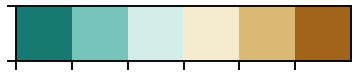

In [45]:
%matplotlib inline
sequential_colors = sns.color_palette('BrBG_r',6)
# sequential_colors = sns.color_palette('OrRd',5)
sns.palplot(sequential_colors)

In [154]:
#compute features
# compute_features_oneside(Theta_filt, winlen=5, overlap=.5)
for subj, cycle in (scores[['SubjID','Visit']].values).tolist():
    print(subj,cycle)
    savepath = '/Users/luca/Box/CISPD_Videos_proc/Figs/AHM'
    for side in ['R','L']:     
        task = 'Ram'+side


,F_dom,F_dom_ratio,spd_var,entropy_psd
2.5,1.192053,0.587078,18.764418,0.293133
5.0,1.192053,0.487216,16.145572,0.300935
7.5,0.993377,0.616427,14.825830,0.297525
10.0,0.993377,0.519600,13.211912,0.301395
12.5,0.794702,0.543072,10.917200,0.296479
15.0,0.993377,0.484238,11.274018,0.344588


## Run on single subject

     SubjID Visit TaskAbb  Tremor - L  Tremor - R  Bradykinesia - R  \
756    1019     3    RamL         1.0         0.0               NaN   

     Bradykinesia - L  Dyskinesia - L  Dyskinesia - R  
756               1.0             0.0             0.0  


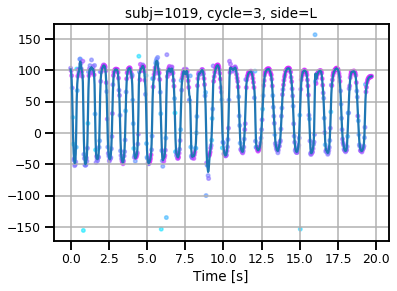

In [49]:
#hand orientation - where is the thumb-pinky vector pointing?
# plt.close('all')
#filter dataframe for subject, task and cycle
#for each side calculate thumb-pinky vector
#calculate the atan2 on this vector at each time step
#return angle
subj = 1019
cycle = 3
task = 'Ram'
side = 'L'

task = task+side
dfs = df.query('SubjID == @subj & Task==@task & cycle==@cycle').copy() 
joints = ['thumb'+side+'_', 'pinky'+side+'_']
j = []
xs = ['x','y']
for jj in product(joints,xs):
    j.append(''.join(jj))
#x-y coordinates of thumb and pinky
dfs_c = dfs[[j+'c' for j in joints]]
conf = dfs_c.mean(axis=1) #thumb and index confidence values
dfs = dfs[j]
Theta_filt = hand_theta(dfs, conf, plot=True)

sdf = scores.query('SubjID==@subj & Visit==@cycle & TaskAbb==@task')
print(sdf)



# savepath = '/Users/luca/Box/CISPD_Videos_proc/Figs/Test'
savepath = None
plt.title(f'subj={subj}, cycle={cycle}, side={side}')
plt.grid()
if savepath is not None:
    if not os.path.exists(savepath):
        os.makedirs(savepath, exist_ok=True)
    plt.savefig(os.path.join(savepath, str(f'{subj}_{task}_{cycle}_{side}.jpg')), dpi=300)
    plt.clf()
    plt.close('all')

In [68]:
# task
# plt.figure()
F_all.query('SubjID == @subj').groupby('Cycle').mean().iloc[:,:4]

,F_dom,F_dom_ratio,spd_var,entropy_psd
Cycle,,,,
1,0.778146,0.385236,15.092681,0.435489
3,1.887417,0.437754,24.347801,0.411870


In [71]:
feats = F_all.query('SubjID == @subj').groupby('Cycle').mean().iloc[:,:4]/F_all.query('SubjID == @subj').groupby('Cycle').max().iloc[:,:4]

In [80]:
%matplotlib qt
feats.drop('F_dom_ratio',axis=1).plot(kind='bar', alpha=.5)

In [256]:
#spectrogram 
from scipy.signal import spectrogram
N = 128
overlap = 0.25
Noverlap = int(N*0.25)
Fs = 30
f, t, Sxx = spectrogram(Theta_filt, fs=Fs, window='hamming', nperseg=N, noverlap=Noverlap)
Sxx = np.log(Sxx)

fig,ax = plt.subplots(2,1, figsize=(12,5))
ax[0].plot(Theta_filt.index, Theta_filt)
ax[1].pcolormesh(t, f, Sxx)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')


Text(0.5, 0, 'Time [sec]')

In [257]:
plt.close('all')

In [126]:
#finger vectors
thumb = np.array([dfs.iloc[:,0], dfs.iloc[:,1]]).T
pinky = np.array([dfs.iloc[:,2], dfs.iloc[:,3]]).T
Theta = find_angle(thumb, pinky)

In [131]:
Theta = pd.Series(data=Theta, index=dfs.index)
Theta.index /= 30 
Theta_filt.index.name = 'Time [s]'

In [144]:
plt.figure()
Theta.plot()
#remove outliers
Theta_filt = removeOutliers(Theta, returnZ=False)
Theta_filt.plot()
#smoothing
x_filt = gaussian_filter1d(Theta_filt, sigma=1)
Theta_filt = pd.Series(data=x_filt, index=Theta_filt.index)
Theta_filt.plot()

In [121]:
plt.figure()
plt.plot(find_angle(thumb, pinky))

In [99]:
plt.close('all')

In [120]:
#old implementation - orientation relative to trunk

savepath = '/Users/luca/Box/CISPD_Videos_proc/Figs/'+str(subj)
dfs = df.query('SubjID == @subj & Task==@task & cycle==@cycle').copy()
side = 'L'
hand, trunk, theta, theta_c = handpose(dfs, side)
theta.iloc[:,-1].plot()
# plot_hand_orientation(df, subj, side, cycle=cycle, task='Ram'+side, fingers=['pinky'+side],
#                       savepath=savepath)

frac detection missing: 0.0


In [98]:
#save hand orientation for all subjects
for subj, cycle in (scores[['SubjID','Visit']].values).tolist():
    print(subj,cycle)
    savepath = '/Users/luca/Box/CISPD_Videos_proc/Figs/AHM'
    for side in ['R','L']:     
        task = 'Ram'+side
        plot_hand_orientation(df, subj, side, cycle=cycle, task=task, fingers=['pinky'+side],
                      savepath=savepath)
        plt.close('all')


1005 1
no data found
no data found
1005 1
no data found
no data found
1005 2
frac detection missing: 0.0019230769230769232
mean confidence pinkyR = 0.4867836644315994
frac detection missing: 0.0
mean confidence pinkyL = 0.6785628634418603
1005 2
frac detection missing: 0.0019230769230769232
mean confidence pinkyR = 0.4867836644315994
frac detection missing: 0.0
mean confidence pinkyL = 0.6785628634418603
1005 3
no data found
no data found
1005 3
no data found
no data found
1007 1
frac detection missing: 0.0
mean confidence pinkyR = 0.5702266136160715
frac detection missing: 0.0
mean confidence pinkyL = 0.4608276042824603
1007 1
frac detection missing: 0.0
mean confidence pinkyR = 0.5702266136160715
frac detection missing: 0.0
mean confidence pinkyL = 0.4608276042824603
1007 2
no data found
no data found
1007 2
no data found
no data found
1007 3
frac detection missing: 0.0
mean confidence pinkyR = 0.45046493763676165
frac detection missing: 0.0
mean confidence pinkyL = 0.415643777334754

frac detection missing: 0.0041841004184100415
mean confidence pinkyL = 0.036911601957894766
1043 1
frac detection missing: 0.022222222222222223
mean confidence pinkyR = 0.3545377791295545
frac detection missing: 0.1509433962264151
mean confidence pinkyL = 0.14828473586956517
1043 1
frac detection missing: 0.022222222222222223
mean confidence pinkyR = 0.3545377791295545
frac detection missing: 0.1509433962264151
mean confidence pinkyL = 0.14828473586956517
1043 2
no data found
no data found
1043 2
no data found
no data found
1043 3
frac detection missing: 0.01984126984126984
mean confidence pinkyR = 0.02148815653984065
frac detection missing: 0.0
mean confidence pinkyL = 0.0502333134345794
1043 3
frac detection missing: 0.01984126984126984
mean confidence pinkyR = 0.02148815653984065
frac detection missing: 0.0
mean confidence pinkyL = 0.0502333134345794
1044 1
frac detection missing: 0.0
mean confidence pinkyR = 0.29000430735551663
no data found
1044 1
frac detection missing: 0.0
mean 

In [33]:
plot_hand_orientation(df, s=1023, cycle=1, fingers=[])

,thumbR_x,thumbR_y,pinkyR_x,pinkyR_y
FrameID,,,,
0,571.513,365.074,532.092,412.004
1,567.623,343.897,531.974,399.559
2,567.711,331.231,521.056,384.025
3,568.699,326.965,499.493,362.471
4,568.359,316.125,512.134,348.167


In [170]:
#compute scores for both sides
F_all = pd.DataFrame()
for subj, cycle in (scores[['SubjID','Visit']].values).tolist():
    print(subj,cycle)
    for side in ['R','L']:     
        task = 'Ftn'+side
        #compute distance from body landmark
        try:
            x = dist_from_ref(df, subj, cycle=cycle, side=side, task=task)
        except:
            print('cannot compute joint displacement - dist_from_ref failed')
            continue
        if x is not None:
            F = compute_features_oneside(x, winlen=10, overlap=0.5)
            #merge scores with features table
            sdf = scores.query('SubjID==@subj & Visit==@cycle & TaskAbb==@task')
            F['SubjID'] = subj 
            F['Cycle'] = cycle 
            F['Tremor'] = sdf['Tremor - '+side].values[-1]
            F['Bradykinesia'] = sdf['Bradykinesia - '+side].values[-1]    
            F['side'] = side
            F_all = pd.concat((F_all, F),axis=0)
        
F_all['total_score'] = F_all.Tremor + F_all.Bradykinesia
F_all.dropna(inplace=True)
print(F_all.total_score.unique())

1005 1
1005 1
1005 2
1005 2
1005 3
no joint data found
no joint data found
1005 3
no joint data found
no joint data found
1007 1
no joint data found
1007 1
no joint data found
1007 2
no joint data found
no joint data found
1007 2
no joint data found
no joint data found
1007 3
no joint data found


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


1007 3
no joint data found
1009 1
no joint data found
1009 1
no joint data found
1009 2
no joint data found
no joint data found
1009 2
no joint data found
no joint data found
1009 3
1009 3
1016 1
no joint data found
1016 1
no joint data found
1016 2
no joint data found
no joint data found
1016 2
no joint data found
no joint data found
1016 3
1016 3
1018 1
no joint data found
1018 1
no joint data found
1018 2
no joint data found
no joint data found
1018 2
no joint data found
no joint data found
1018 3
no joint data found
1018 3
no joint data found
1019 1
1019 1
1019 2
no joint data found
no joint data found
1019 2
no joint data found
no joint data found
1019 3
1019 3
1020 1
no joint data found
1020 1
no joint data found
1020 2
no joint data found
no joint data found
1020 2
no joint data found
no joint data found
1020 3
1020 3
1023 1
savgol filter did not converge
1023 1
savgol filter did not converge
1023 2
no joint data found
no joint data found
1023 2
no joint data found
no joint data

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


cannot compute joint displacement - dist_from_ref failed
1032 3
cannot compute joint displacement - dist_from_ref failed
1038 1
no joint data found
1038 1
no joint data found
1038 2
no joint data found
no joint data found
1038 2
no joint data found
no joint data found
1038 3
1038 3
1039 1
1039 1
1039 2
no joint data found
no joint data found
1039 2
no joint data found
no joint data found
1039 3
1039 3
1043 1
1043 1
1043 2
no joint data found
no joint data found
1043 2
no joint data found
no joint data found
1043 3
1043 3
1044 1
no joint data found
1044 1
no joint data found
1044 2
no joint data found
no joint data found
1044 2
no joint data found
no joint data found
1044 3
no joint data found
1044 3
no joint data found
1046 1
no joint data found
no joint data found
1046 1
no joint data found
no joint data found
1046 2
no joint data found
no joint data found
1046 2
no joint data found
no joint data found
1046 3
1046 3
1047 1
1047 1
1047 2
no joint data found
no joint data found
1047 2
n

In [175]:
F_all.columns

Index(['F_dom', 'F_dom_ratio', 'spd_var', 'entropy_psd', 'SubjID', 'Cycle',
       'Tremor', 'Bradykinesia', 'side', 'total_score'],
      dtype='object')

In [182]:
F_all.groupby(['SubjID'])['Cycle'].unique()

SubjID
1005    [1, 2]
1007    [1, 3]
1009    [1, 3]
1016    [1, 3]
1018    [1, 3]
1019    [1, 3]
1023    [1, 3]
1024    [1, 3]
1029    [1, 3]
1030    [1, 3]
1032    [1, 3]
1038    [1, 3]
1039    [1, 3]
1043    [1, 3]
1044    [1, 3]
1046       [3]
1047    [1, 3]
1049    [1, 3]
1050       [2]
1051    [1, 3]
1054       [3]
1055    [1, 3]
1056    [1, 2]
Name: Cycle, dtype: object

In [149]:
plt.close('all')

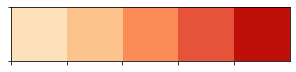

In [166]:
%matplotlib inline
# sequential_colors = sns.color_palette('BrBG_r',5)
sequential_colors = sns.color_palette('OrRd',5)
sns.palplot(sequential_colors)

In [174]:
#plot features - sum tremor and bradykinesia scores
%matplotlib qt
sns.pairplot(F_all.drop(labels=['SubjID', 'Tremor', 'Bradykinesia', 'Cycle'],axis=1), hue='total_score', 
             plot_kws=dict(alpha=0.8), diag_kind='kde', palette=sequential_colors)
plt.tight_layout()

In [164]:
#plot features - med state
colors = ['medium green','pale red']
binary_pal = sns.xkcd_palette(colors)
F_all['medication_state'] = 'ON'
F_all.loc[((F_all.Bradykinesia > 0) | (F_all.Tremor > 0)), 'medication_state'] = 'OFF'

%matplotlib qt
sns.pairplot(F_all.drop(labels=['SubjID','Cycle', 'side', 'Tremor', 'Bradykinesia', 'total_score'],axis=1), hue='medication_state', 
             plot_kws=dict(alpha=0.5), diag_kind='kde', palette=binary_pal)
plt.tight_layout()

In [140]:
#plot features - bradykinesia only
%matplotlib qt
sns.pairplot(F_all.drop(labels=['SubjID', 'Tremor', 'total_score'],axis=1), hue='Bradykinesia', 
             plot_kws=dict(alpha=0.5), diag_kind='hist', palette=sequential_colors)
plt.tight_layout()

In [150]:
#build classifier


In [100]:
#features on one side only
# F_all = pd.DataFrame()
# for subj, cycle in (scores[['SubjID','Visit']].values).tolist():
#     print(subj,cycle)
#     #compute distance from body landmark
#     x = dist_from_ref(df, subj, cycle=cycle, side='R', task='FtnR')
#     if x is not None:
#         F = compute_features_oneside(x, winlen=5, overlap=0.5)
#         #merge scores with features table
#         sdf = scores.query('SubjID==@subj & Visit==@cycle')
#         F['SubjID'] = subj 
#         F['Tremor'] = sdf['Tremor - R'].values[-1]
#         F['Bradykinesia'] = sdf['Bradykinesia - R'].values[-1]      
#         F_all = pd.concat((F_all, F),axis=0)
        
# F_all['total_score'] = F_all.Tremor + F_all.Bradykinesia
# F_all.dropna(inplace=True)
# print(F_all.total_score.unique())

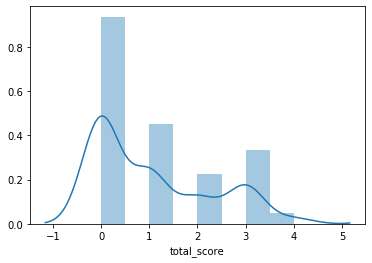

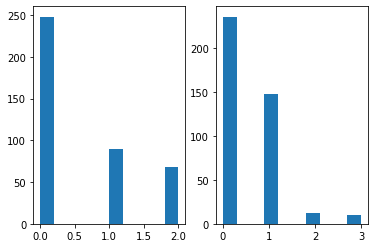

In [90]:
%matplotlib inline
plt.figure()
sns.distplot(F_all.total_score)
fig,ax = plt.subplots(1,2)
a = ax[0].hist(F_all.Tremor)
a = ax[1].hist(F_all.Bradykinesia)

## Other palettes

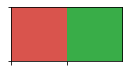

In [45]:
colors = ['pale red','medium green']
sns.palplot(sns.xkcd_palette(colors))